# The Hopfield network

A Hopfield network is a form of recurrent artificial neural network popularized by John Hopfield in [1982](http://www.ncbi.nlm.nih.gov/pubmed/6953413).   It is an autoassociative network, which means that it can store a piece of data given as the activation of its own units and then retrieve it when you trigger a subpopulation of its units that is equal to a tiny sample of the same piece of data.
Learning is done by changing the weights of the connections between its units in a  *fake* hebbian way. You treat each input pattern as if it were the vector of the activations of units and highten the weights of the connections between concurrently active units. 

figure 1: an abstract example showing the functioning of an autoassociative network. On the left the network weights after learning. On the center, we trigger only one unit. On the right, all the associated units become activated.

![figure_1](hopfield.png)

### Spreading

The activation of a unit in a Hopfield network is updated by evaluating the sign of the weighted sum of its inputs:
<table width="100%">
<tr>
<td>
<img src="sign_function.png" alt="sign_function" width="300" >
</td>
</tr>
<tr>
<td>
$$ 
x_i = \begin{cases}
  -1  & \quad \text{if } \sum_{j} w_{ij}x_j <  0\\
   1  & \quad \text{otherwise}\\
  \end{cases}
$$ 
</td>
</tr>
</table>
There are two ways to implement the update of the units: **synchronous** and **asynchronous** update.  

#### Syncronous update

The units are updated altogether at each step, using as inputs the *freezed* activations of themselves at the previous step. 

In python you can write:

```python
# n = len(x)
for i in xrange(n): 
    w_sum = 0
    for j in xrange(n):
        w_sum += w[i,j]*x_previous[j]
    x[i] = sgn(w_sum)
...
...
x_previous = x
```
Using linear algebra we can rewrite it in a shorter form as:
$$
\mathbf{x} = sgn(\mathbf{W}\mathbf{x})
$$
where $\mathbf{x}$ is the vector of activations, $\mathbf{W}$ is the matrix of inner weights and all the weighted sums are calculated at once with the [dot product](https://en.wikipedia.org/wiki/Dot_product#Algebraic_definition) $\mathbf{W}\mathbf{x}$. 
Linear algebra notation is a far better way to implement neural networks in a program than iterating units. In particular, writing formulas with linear algebra notation in python (through the numpy library) improves both speed and readability. In the case of units activations in python you can write:
```python
x = sgn(dot(w,x))
```
that is far simpler than writing two nested loops and storing previous values in another vector, and also produces a much efficient 
code in terms of speed!!  

#### Asynchronous update

At each step a unit is randomly chosen for the update, while the others remain immutated. In python you write:
```python
i = chosen_index
w_sum = 0
for j in xrange(n):
    w_sum += w[i,j]*x[j]
x[i] = sgn(w_sum)
```
Using linear algebra leads to a shorter form also in this case:`

```python
i = chosen_index
x[i] = sgn(w[i,:],x)
```
Note how we don't need to store previous values here. 

In the simulation described below we will use asynchronous update (in a way it seems more biologicaly plausible).

### Learning

The learning of the weights is done offline at the start of the simulation. To update the weights you just treat each pattern $\mathbf{p}_k$ (with $k = 1,...,n_p$) as if it were the current vector of activations of the network units and increase those weights where the activity at the two endings are high ([hebbian learning](https://en.wikipedia.org/wiki/Hebbian_theory#Principles)). This is done in practice by multiplying the two activities at the endings of each weight. The total amount of update is then calculated by adding together all the increments due to the different patterns to be learned. Finally the result is divided times the number of patterns to learn so that the weights are normalized. Putting it all together you have:
$$
w_{i,j} = \frac{1}{n_p} \sum_k p^k_i p^k_j 
$$
In python we can write:
```python
w = zeros([n,n])
# P is an array of p vectors 
for p in P:    
    # np = len(p)
    for i in xrange(np):  
        for j in xrange(np):
            # autoconnections are 
            # forbidden in Hopfield nets
            if i != j :     
                w[i,j] += (1/float(np))*p[i]*p[j]
```
Where `P` is an array with `np` rows of `p` patterns.

Once again linear algebra can help us and we can rewrite the learning rule as:
$$
    \mathbf{W} = \frac{1}{n_p}\sum_k \mathbf{p}_k \mathbf{p}_k^T
$$
Where  $ \mathbf{p}_k \mathbf{p}_k^T$ is the [outer product](https://en.wikipedia.org/wiki/Outer_product#Definition_.28matrix_multiplication.29) of $\mathbf{p}_k$ with itself. In python it becomes:
```python
# accumulate dot products
for p in P:
    w += (1/float(np))*outer(p,p)

# cut autoconnections afterward
w *= 1.0 - eye(n,n)     
```
In this case we have only one loop instead of three!! 
<p></p>



>* A general rule: the **dot product** is for spreading the activity throughout a network, while the **outer product** is for weight update

### Energy function
In each state of the network we can calculate a value that is given by:
$$
E = -\frac{1}{2}\sum_{i,j}w_{i,j}x_{i}x_{j}
$$
or in linear algebra notation:
$$
E = -\frac{1}{2} \mathbf{x}^T\mathbf{W}\mathbf{x}
$$
Hopfield proved that this value can only decrease or stay the same. When $E$ ceases to change the network has reached one of its attractor states. if the learned patterns are sufficiently orthogonal with each other attractor states correspond to the recalled patterns.

In python it is:
```python
E = -0.5*dot(x,dot(w,x))
```

## Implementing a simulation

In [25]:
%matplotlib inline
from pylab import *

Let us implement a simulation using images from [the MNIST dataset](http://nbviewer.ipython.org/github/francesco-mannella/neunet-basics/blob/master/course/mnist.ipynb) as patterns.

#### Init the dataset
First we initialize the dataset:

In [26]:
#### download the dataset 
# get the script from internet
! wget https://raw.githubusercontent.com/sorki/python-mnist/master/get_data.sh > /dev/null 2>&1  
# run it to dovnload all files in a local dir named 'data'
! bash get_data.sh >/dev/null 2>&1
# we do not need the script anymore, remove it
! rm get_data.sh* > /dev/null 2>&1

# initialize the dataset variables

%run utils

We now fill a array with all parameters. We only need few samples, we take them from the training set. 
We take samples 2 and 5, representing respectively a '4' and a '2'

In [27]:
# take two rows
patterns = array(mndata.train_images)[[2,5],]
# we need only the sign (transform to binary input)
patterns = sign(patterns/255.0 - 0.5)

# set the number of patterns (two in out case)
n_patterns = patterns.shape[0]

Let us visualize our two patterns:

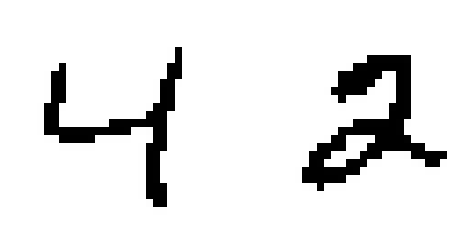

In [28]:
fig = figure(figsize = (8, 4))
for i in xrange(n_patterns):
    plot_img( to_mat(patterns[i]), 
             fig, i+1, windows = 2 )

#### The learning 

Learning of the weight happens offline at the beginning, in one shot:

In [29]:
# initialize weights to zero values
W = zeros([n,n])

# accumulate outer products 
for pattern in patterns :
    W += outer(pattern, pattern)

# divide times the number of patterns
W /= float(n_patterns)

# exclude the autoconnections
W *= 1.0 - eye(n, n)

#### The real simulation, iterating the timesteps

Now we implement th core part, defining what happens in each timestep

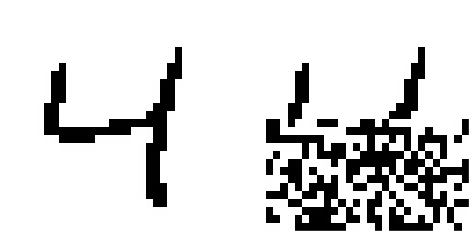

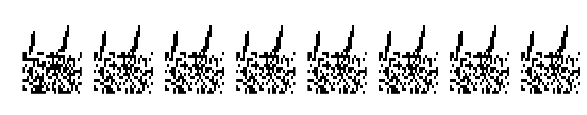

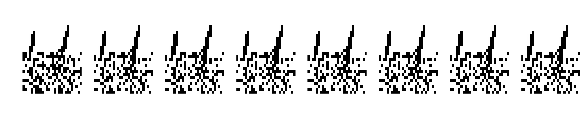

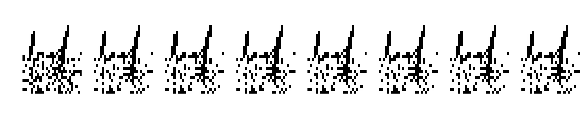

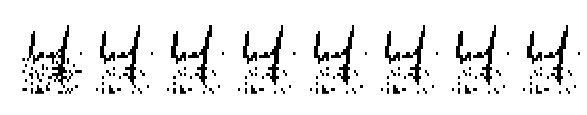

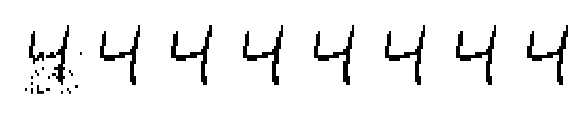

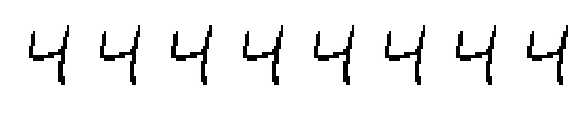

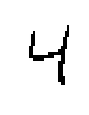

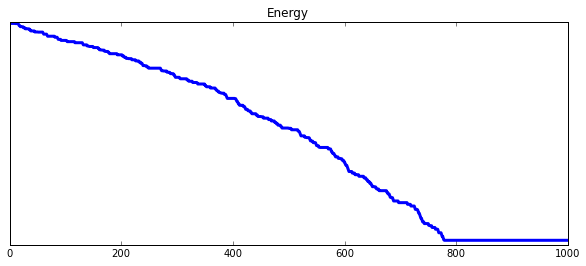

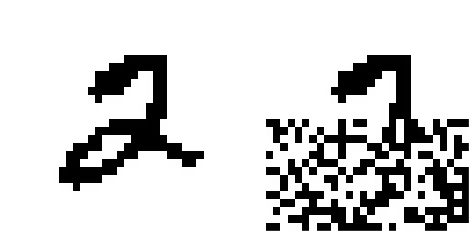

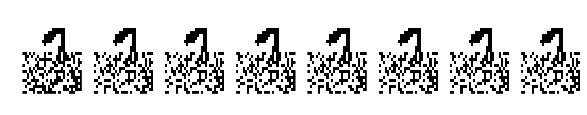

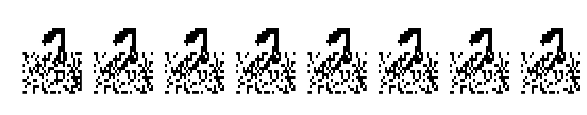

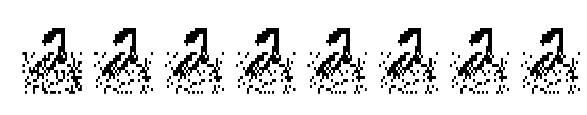

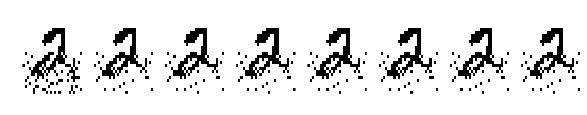

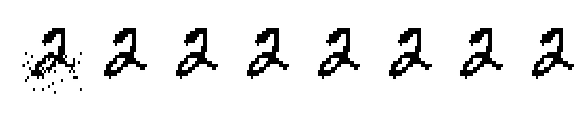

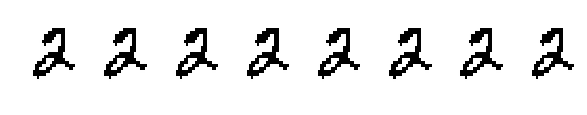

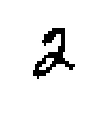

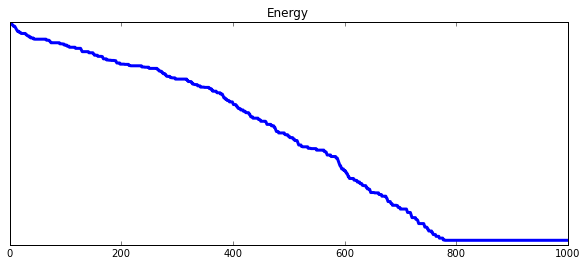

In [9]:
# number of timesteps
stime = 1000

# we simulate two iteration, each one starting
# with a coorupted version of one of our two patterns
for target_index in [0, 1] :

    # first copy the original pattern
    target = patterns[target_index]
    x = target.copy()
    # then modify the second half of the image 
    # putting random binary values
    x[(n/2):] = sign(randn(n/2))

    #------------------------------------------------ 
    #--- PLOTTING ----------------------------------- 
    #------------------------------------------------ 
    # we plot the target and its corrupted version 
    # from which we start
    fig = figure(figsize=(8,4))        
    plot_img( to_mat(target), fig, 1, windows = 2)
    plot_img( to_mat(x), fig, 2, windows = 2)
    win_count = 0
    #------------------------------------------------ 
    #------------------------------------------------
    
    # during the iterations we need to peek 
    # one unit at random. Thus we must prepare
    # a random sequence of indices:
    #    we get the sequence of indices 
    #    of the network units
    x_indices = arange(n)
    #    and we shuffle it
    shuffle(x_indices)
    
    # init the story of energy to a zero vector,
    # we will fill it in at each timestep and we will 
    # plot it at the end
    E = zeros(stime)
    
    # the iterations
    for t in xrange(stime) :
        # we get the current index browsing 
        # the random sequence 
        current_x = x_indices[t%n]   
        
        # activation of a unit
        x[current_x] = sign(dot(W[current_x,:], x))
        
        # energy of the current state of the network
        E[t] = -0.5*dot(x, dot(W, x))
        
        #--------------------------------------------
        #--- PLOTTING ------------------------------- 
        #--------------------------------------------
        current_window = t%windows + 1  
        # we plot each 20th step
        if win_count%20 == 0 :
            
            # change row at each 'windows'th plot
            if current_window == 1 :
                fig = figure(figsize = (10, 1.5))    
                
            plot_img(to_mat(x), fig, current_window)
            
            if current_window == windows :
                show()
        
        win_count += (t%windows == 0)
        #--------------------------------------------
        #--------------------------------------------
    
    
    # plot the energy
    figure(figsize = (10, 4)) 
    title("Energy")
    plot(E, linewidth = 3)
    gca().yaxis.set_visible(False)
    show()
    

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
Next cell is just for styling

In [43]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../style/ipybn.css", "r").read()
    return HTML(styles)
css_styling()